In [2]:
import os

# set the environment variable to control the number of threads
# NEEDS TO BE DONE BEFORE CCL IS IMPORTED
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import emcee
import parallelbar

import src.datamaker as dm

from scipy.interpolate import interp1d
from scipy.integrate import simps

from multiprocessing import Pool, cpu_count

from time import time, sleep
from importlib import reload
reload(dm)

<module 'src.datamaker' from '/home/b7009348/CosyMAML/src/datamaker.py'>

In [3]:
def Smail_dndz(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

def convolve_photoz(sigma, zs, dndz_spec, return_2d=False):

     # Convolve with photo-z
    sigma_z = sigma * (1 + zs)

    z_ph = np.linspace(0.05, 4.0, 300)

    # find probability of galaxy with true redshift z_s to be measured at redshift z_ph
    integrand1 = np.zeros([len(zs),len(z_ph)])
    p_zs_zph = np.zeros([len(zs),len(z_ph)])
    for j in range(len(zs)):
        p_zs_zph[j,:] =  (1. / (np.sqrt(2. * np.pi) * sigma_z[j])) * np.exp(-((z_ph - zs[j])**2) / (2. * sigma_z[j]**2))

    integrand1 = p_zs_zph * dndz_spec[:,None]   

    # integrate over z_s to get dN
    integral1 = simps(integrand1, zs, axis=0)
    dN = integral1
    
    dz_ph = simps(dN, z_ph)

    if return_2d:
        return z_ph, dN/dz_ph, p_zs_zph
    
    return z_ph, dN/dz_ph

CDF values: [0.  0.5 1. ]
Bin edges (z): [0.18947578 0.67843433 2.74449819]


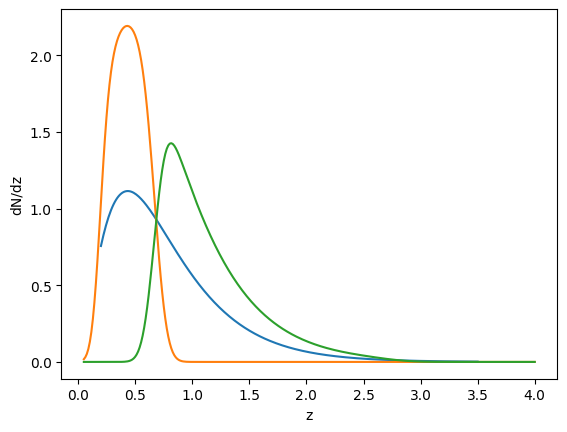

In [4]:
# Generate the redshift distribution
z = np.linspace(0.2, 3.5, 300)
z0 = 0.13
alpha = 0.78

def Smail_dndz(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

dndz_s = Smail_dndz(z, z0, alpha)

# Normalize the distribution
area = simps(dndz_s, z)  # Integrate dndz_s over z to get the area under the curve
pdf = dndz_s / area  # Normalize to make it a PDF

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf) * (z[1] - z[0])  # Approximate the integral to get the CDF

# Interpolate the CDF to find the bin edges
inverse_cdf = interp1d(cdf, z, fill_value="extrapolate")

n_bins = 2

# Define the CDF values for the bin edges
cdf_values = np.linspace(0, 1, n_bins+1)
print("CDF values:", cdf_values)
# Find the corresponding z values (bin edges) for these CDF values
bin_edges = inverse_cdf(cdf_values)

# Print the bin edges
print("Bin edges (z):", bin_edges)

plt.figure()
plt.plot(z, pdf, label='True dndz')

zs = []
dndz_spec_bins = []
dndz_ph_bins = []
for i in range(n_bins):
    zs.append(np.linspace(bin_edges[i], bin_edges[i+1], len(z)))
    dndz_spec_bins.append(Smail_dndz(zs[i], z0, alpha)) # Store spec bins to produce slighty different photo-z bins later

    z_ph, dndz_ph = convolve_photoz(0.05, zs[i], dndz_spec_bins[i])
    dndz_ph_bins.append(dndz_ph) # fiducial photo-z bins

    # Norm with respect to full dndz
    plt.plot(z_ph, dndz_ph_bins[i], label='Photo-z convolved')
    plt.xlabel('z')
    plt.ylabel('dN/dz')

Mean before shift: 0.8045261490021662
Mean after shift: 0.9045261490021661
Delta z: 0.09999999999999987


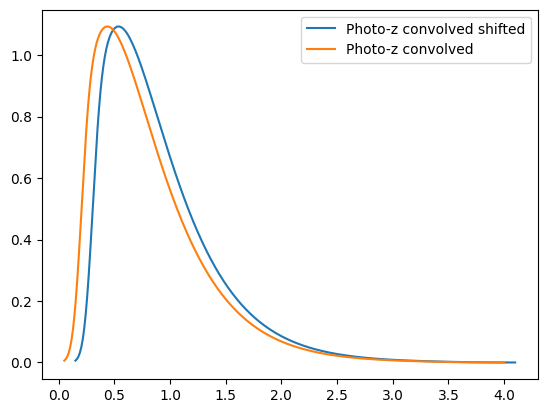

In [13]:
# Try to shift the mean
delta_z = 0.1
mean = np.average(z_ph, weights=dndz_ph)
z_ph_shifted = z_ph + delta_z#*(1 + mean)
z_ph_shifted[z_ph_shifted < 0] = 0

mean_shifted = np.average(z_ph_shifted, weights=dndz_ph)
print("Mean before shift:", mean)
print("Mean after shift:", mean_shifted)
print("Delta z:", mean_shifted - mean)

plt.plot(z_ph_shifted, dndz_ph, label='Photo-z convolved shifted')
plt.plot(z_ph, dndz_ph, label='Photo-z convolved')
plt.legend()

Text(0.5, 1.0, 'LSST Y1 photo-z model')

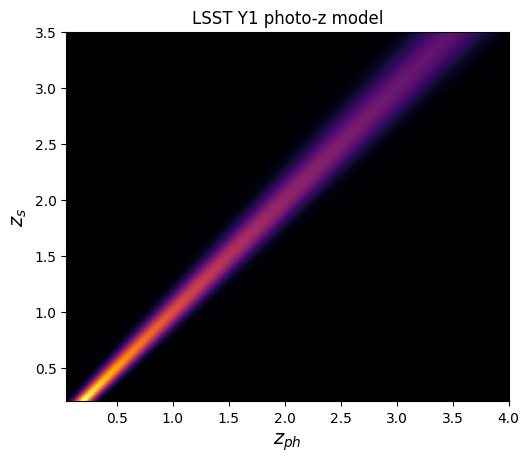

In [12]:
z_ph, dndz_ph, pz_s_zph = convolve_photoz(0.05, z, pdf, return_2d=True)

plt.imshow(pz_s_zph, aspect='equal', extent=[0.05, 4.0, 0.2, 3.5], origin='lower', cmap='inferno')
plt.xlabel(r'$z_{ph}$', fontsize=14)
plt.ylabel(r'$z_s$', fontsize=14)
plt.title('LSST Y1 photo-z model')

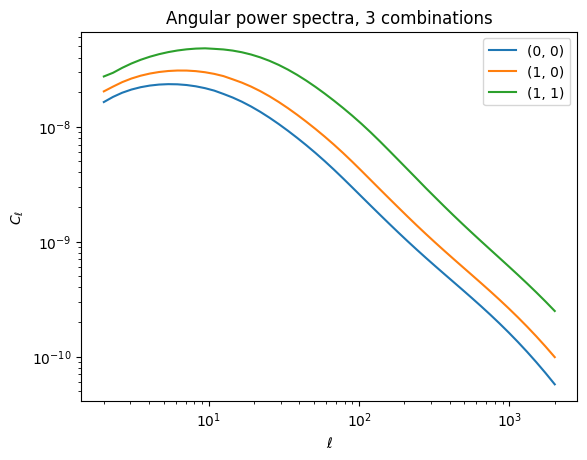

In [13]:
# Create mock observational data
# Define the cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96, matter_power_spectrum='halofit')

ells = np.geomspace(2, 2000)

# Compute auto and cross spectra
indices = np.tril_indices(n_bins)
zipped_inds = list(zip(*indices))

plt.figure()
c_ells = np.empty((len(zipped_inds), len(ells)))
for i, arg in enumerate(zipped_inds):
    j, k = arg
    tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[j]))
    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[k]))
    c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells, l_limber='auto')
    plt.loglog(ells, c_ells[i], label=f'({j}, {k})', ls='-')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_\ell$')
    plt.legend()
    plt.title('Angular power spectra, {} combinations'.format(len(zipped_inds)))

In [5]:
data_vector = c_ells.flatten() # Flatten the array to make it a vector

# Add noise
noise = 0.1 * data_vector
data_vector += np.random.normal(0, noise)

# generate covariance matrix
cov = np.diag(noise**2)
inv_cov = np.linalg.inv(cov)

plt.figure()
plt.plot(data_vector)
plt.xlabel('Index')
plt.ylabel('Data')
plt.yscale('log')
plt.title('Data vector with noise')

NameError: name 'c_ells' is not defined

In [14]:
# Define the likelihood function
def log_likelihood(theta, data, inv_cov):
    cosmo = ccl.Cosmology(Omega_c=theta[0], Omega_b=theta[1], h=theta[2], sigma8=theta[3], n_s=theta[4], matter_power_spectrum='halofit')
    model = np.empty((len(zipped_inds), len(ells)))

    # Shift mean of photo-z bins based on theta
    shifted_z = [] 
    for i in range(n_bins):
        mean_z = np.average(z, weights=dndz_ph_bins[i])
        shifted_z.append(z + theta[5+i]*(1 + mean_z))
        # set any negative values to 0
        shifted_z[i][shifted_z[i] < 0] = 0

    for i, arg in enumerate(zipped_inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(shifted_z[j], dndz_ph_bins[j]))
        tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(shifted_z[k], dndz_ph_bins[k]))
        model[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells, l_limber='auto')

    model_vector = model.flatten()
    diff = data - model_vector
    return -0.5 * np.dot(diff, np.dot(inv_cov, diff))

def log_prior(theta, priors):
    for i, prior in enumerate(priors):
        if not prior[0] < theta[i] < prior[1]:
            return -np.inf
    return 0.0

def log_probability(theta, data, cov, priors):
    lp = log_prior(theta, priors)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, data, cov)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [16]:
np.random.seed(14)

theta = [0.27, 0.045, 0.67, 0.83, 0.96, 0.00, 0.00] # fiducial cosmology

# Initialize the walkers
nwalkers = 32
ndim = len(theta)
chain_len = 100

# Initialize the walkers in a tiny Gaussian ball around the maximum likelihood result
pos = theta + 1e-4 * np.random.randn(nwalkers, ndim)
priors = [(0.1, 0.9), (0.01, 0.1), (0.5, 0.9), (0.7, 1.0), (0.8, 1.1), (-0.002, 0.002), (-0.002, 0.002)]

# test the likelihood function
start = time()
ln_likelihood = log_probability(theta, data_vector, inv_cov, priors)
end = time()
print("Log likelihood: {}".format(ln_likelihood))
print("Time taken: {}s".format(end - start))

-76.70248425553993
Log likelihood: -76.70248425553993
Time taken: 1.5391664505004883s


In [10]:
converged = False

backend = emcee.backends.HDFBackend("test.h5")
backend.reset(nwalkers, ndim)

# Initialise a pool 
with Pool(cpu_count()) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=(data_vector, inv_cov, priors),
        pool=pool,
        backend=backend,

    )
    
    while not converged:
        
        # Sample 
        start = time()
        sampler.run_mcmc(pos, chain_len, progress=True)
        end = time()

        # Update the initial positions
        pos = sampler.get_last_sample()

        # Check convergence
        tau = sampler.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < sampler.iteration)
        print("Current iteration: {}".format(sampler.iteration))
        print("Autocorrelation times: {}".format(tau*50))

        # Estimate completion time
        time_per_iter = (end - start) / sampler.iteration
        time_left = (np.max(tau) * (chain_len - sampler.iteration)) * time_per_iter
        print("Estimated time left: {}s".format(time_left))

TypeError: EnsembleSampler.__init__() got an unexpected keyword argument 'store_blobs'

In [24]:
# Create hypercube of parameters to train an emulator

# Define the parameter space
# Priors from DES Y3 Cosmic shear fits
OmM = np.array([0.1, 0.9])
OmB = np.array([0.03, 0.07])
OmC = OmM - OmB

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

# Generate the hypercube
n_points = 1000
cosmo_hypercube = dm.gen_hypercube(
    Omega_c=OmC,
    Omega_b=OmB,
    h=h,
    sigma8=sigma8,
    n_s=n_s,
    n_samples=n_points
)

args = [
        (
            cosmo_hypercube[i,0],
            cosmo_hypercube[i,1],
            cosmo_hypercube[i,2],
            cosmo_hypercube[i,3],
            cosmo_hypercube[i,4],
            zipped_inds,
            ells,
            z,
            dndz_ph_bins
        ) for i in range(n_points)
    ]

# Compute C_ell for each point in the hypercube in parallel
def compute_cl(Omega_b, Omega_c, h, sigma8, n_s, zipped_inds, ells, z, dndz_ph_bins):
    cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s)
    c_ells = np.empty((len(zipped_inds), len(ells)))
    for i, arg in enumerate(zipped_inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[j]))
        tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[k]))
        c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
        
    return c_ells.flatten()

# Compute the C_ell for each point in the hypercube using parallelbar
n_cores = cpu_count()

c_ells_train = parallelbar.progress_starmap(compute_cl, args, n_cpu=n_cores)

DONE:   0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
# Construct simple MLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the model
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(c_ells_train[0]))
)

# Check for GPU and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# collate training data
X = cosmo_hypercube
print(X.shape)
y = np.array(c_ells_train)
print(y.shape)

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log transform y
y_train = np.log(y_train)
#y_test = np.log(y_test)

# create dataloader
batch_size = 512

# define loss function
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train model
n_epochs = 400
train_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}')

(10000, 5)
(10000, 750)
Epoch 1/400, Loss: 6152.2604
Epoch 2/400, Loss: 5925.6453
Epoch 3/400, Loss: 4285.7500
Epoch 4/400, Loss: 902.2333
Epoch 5/400, Loss: 290.4129
Epoch 6/400, Loss: 188.2627
Epoch 7/400, Loss: 165.0583
Epoch 8/400, Loss: 156.0471
Epoch 9/400, Loss: 149.2250
Epoch 10/400, Loss: 142.4721
Epoch 11/400, Loss: 135.7238
Epoch 12/400, Loss: 129.1754
Epoch 13/400, Loss: 121.4203
Epoch 14/400, Loss: 113.9286
Epoch 15/400, Loss: 105.7286
Epoch 16/400, Loss: 97.1817
Epoch 17/400, Loss: 88.0375
Epoch 18/400, Loss: 78.4972
Epoch 19/400, Loss: 68.9086
Epoch 20/400, Loss: 59.2352
Epoch 21/400, Loss: 49.6439
Epoch 22/400, Loss: 40.4288
Epoch 23/400, Loss: 32.1754
Epoch 24/400, Loss: 24.8221
Epoch 25/400, Loss: 18.7152
Epoch 26/400, Loss: 13.8943
Epoch 27/400, Loss: 10.2936
Epoch 28/400, Loss: 7.7983
Epoch 29/400, Loss: 6.2112
Epoch 30/400, Loss: 5.2214
Epoch 31/400, Loss: 4.6329
Epoch 32/400, Loss: 4.3043
Epoch 33/400, Loss: 4.1049
Epoch 34/400, Loss: 3.9693
Epoch 35/400, Loss: 3.

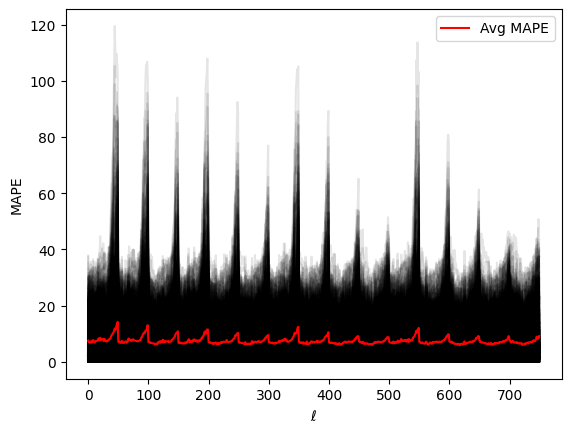

In [28]:
# evaluate model
preds = model(torch.tensor(X_test, dtype=torch.float32).to(device))
preds = preds.cpu().detach().numpy()
preds = np.exp(preds)

# plot mape for all samples along with avg
mape = np.zeros((len(y_test), len(y_test[0])))
for i in range(len(y_test)):
    mape[i] = np.abs(preds[i] - y_test[i]) / y_test[i] * 100
    plt.plot(mape[i], 'k', alpha=0.1)
plt.plot(np.mean(mape, axis=0), 'r', label='Avg MAPE')
plt.xlabel(r'$\ell$')
plt.ylabel('MAPE')
plt.legend()

In [31]:
# Substituting the emulator in the likelihood function
def log_likelihood_emu(theta, data, inv_cov, model):
    cosmo = ccl.Cosmology(Omega_c=theta[0], Omega_b=theta[1], h=theta[2], sigma8=theta[3], n_s=theta[4])
    model_vector = model(torch.tensor(theta, dtype=torch.float32).to('cuda'))
    model_vector = model_vector.cpu().detach().numpy()
    diff = data - model_vector
    return -0.5 * np.dot(diff, np.dot(inv_cov, diff))

def log_prior(theta):
    p1, p2, p3, p4, p5 = theta
    if 0.1 < p1 < 0.9 and 0.03 < p2 < 0.07 and 0.5 < p3 < 0.9 and 0.7 < p4 < 1.0 and 0.8 < p5 < 1.2:
        return 0.0
    return -np.inf

def log_probability_emu(theta, data, cov, model):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_emu(theta, data, cov, model)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [32]:
# Initialize the walkers
nwalkers = 10
ndim = 5
chain_len = 1000

np.random.seed(14)

# Initialize the walkers in a tiny Gaussian ball around the maximum likelihood result
pos = np.array([0.5, 0.05, 0.7, 0.83, 0.96]) + 1e-4 * np.random.randn(nwalkers, ndim)

converged = False

# Initialise a pool 
with Pool(cpu_count()) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability_emu,
        args=(data_vector, inv_cov, model),
    )
    
    while not converged:
        
        # Sample 
        sampler.run_mcmc(pos, chain_len, progress=False)

        # Update the initial positions
        pos = sampler.get_last_sample()

        # Check convergence
        tau = sampler.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < sampler.iteration)
        print("Current iteration: {}".format(sampler.iteration))
        print("Autocorrelation times: {}".format(tau*50))

Current iteration: 1000
Autocorrelation times: [3443.97488108 3027.99011579 5743.01338796 3649.43862369 3309.08424649]
Current iteration: 2000
Autocorrelation times: [3778.14233363 3283.60705295 8102.01950055 4067.79263343 3588.75054938]
Current iteration: 3000
Autocorrelation times: [3849.35716172 3339.88617271 8987.74190768 4160.75889186 3644.86511402]
Current iteration: 4000
Autocorrelation times: [3874.04779142 3360.48451442 9382.44121205 4194.29646002 3663.71157215]
Current iteration: 5000
Autocorrelation times: [3885.20207067 3370.46294212 9587.12600267 4209.68435641 3671.79985085]
Current iteration: 6000
Autocorrelation times: [3890.98052333 3376.06349282 9705.073984   4217.79898133 3675.88648273]
Current iteration: 7000
Autocorrelation times: [3894.36466325 3379.51396633 9779.73246846 4222.55529598 3678.12500853]
Current iteration: 8000
Autocorrelation times: [3896.44919119 3381.79022932 9829.82697327 4225.61312271 3679.42589149]
Current iteration: 9000
Autocorrelation times: [

(12000, 40, 7)


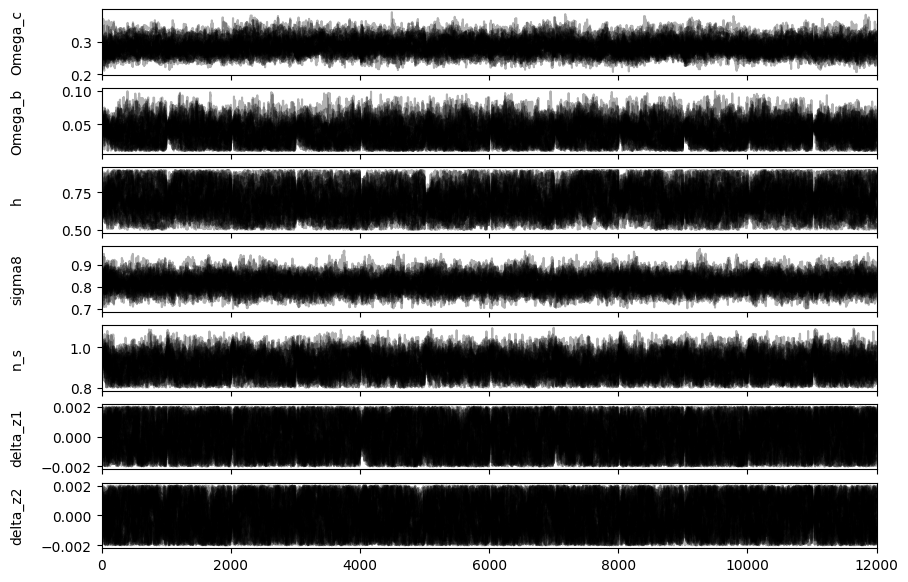

In [3]:
# Test loading data from the backend
reader = emcee.backends.HDFBackend("mcmc/40walkers_chain_outputs.h5")

# Get the chain
samples = reader.get_chain()
print(samples.shape)
ndim = 7

# Plot the chain
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
labels = ["Omega_c", "Omega_b", "h", "sigma8", "n_s", "delta_z1", "delta_z2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [7]:
flat_samples = reader.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(29320, 7)


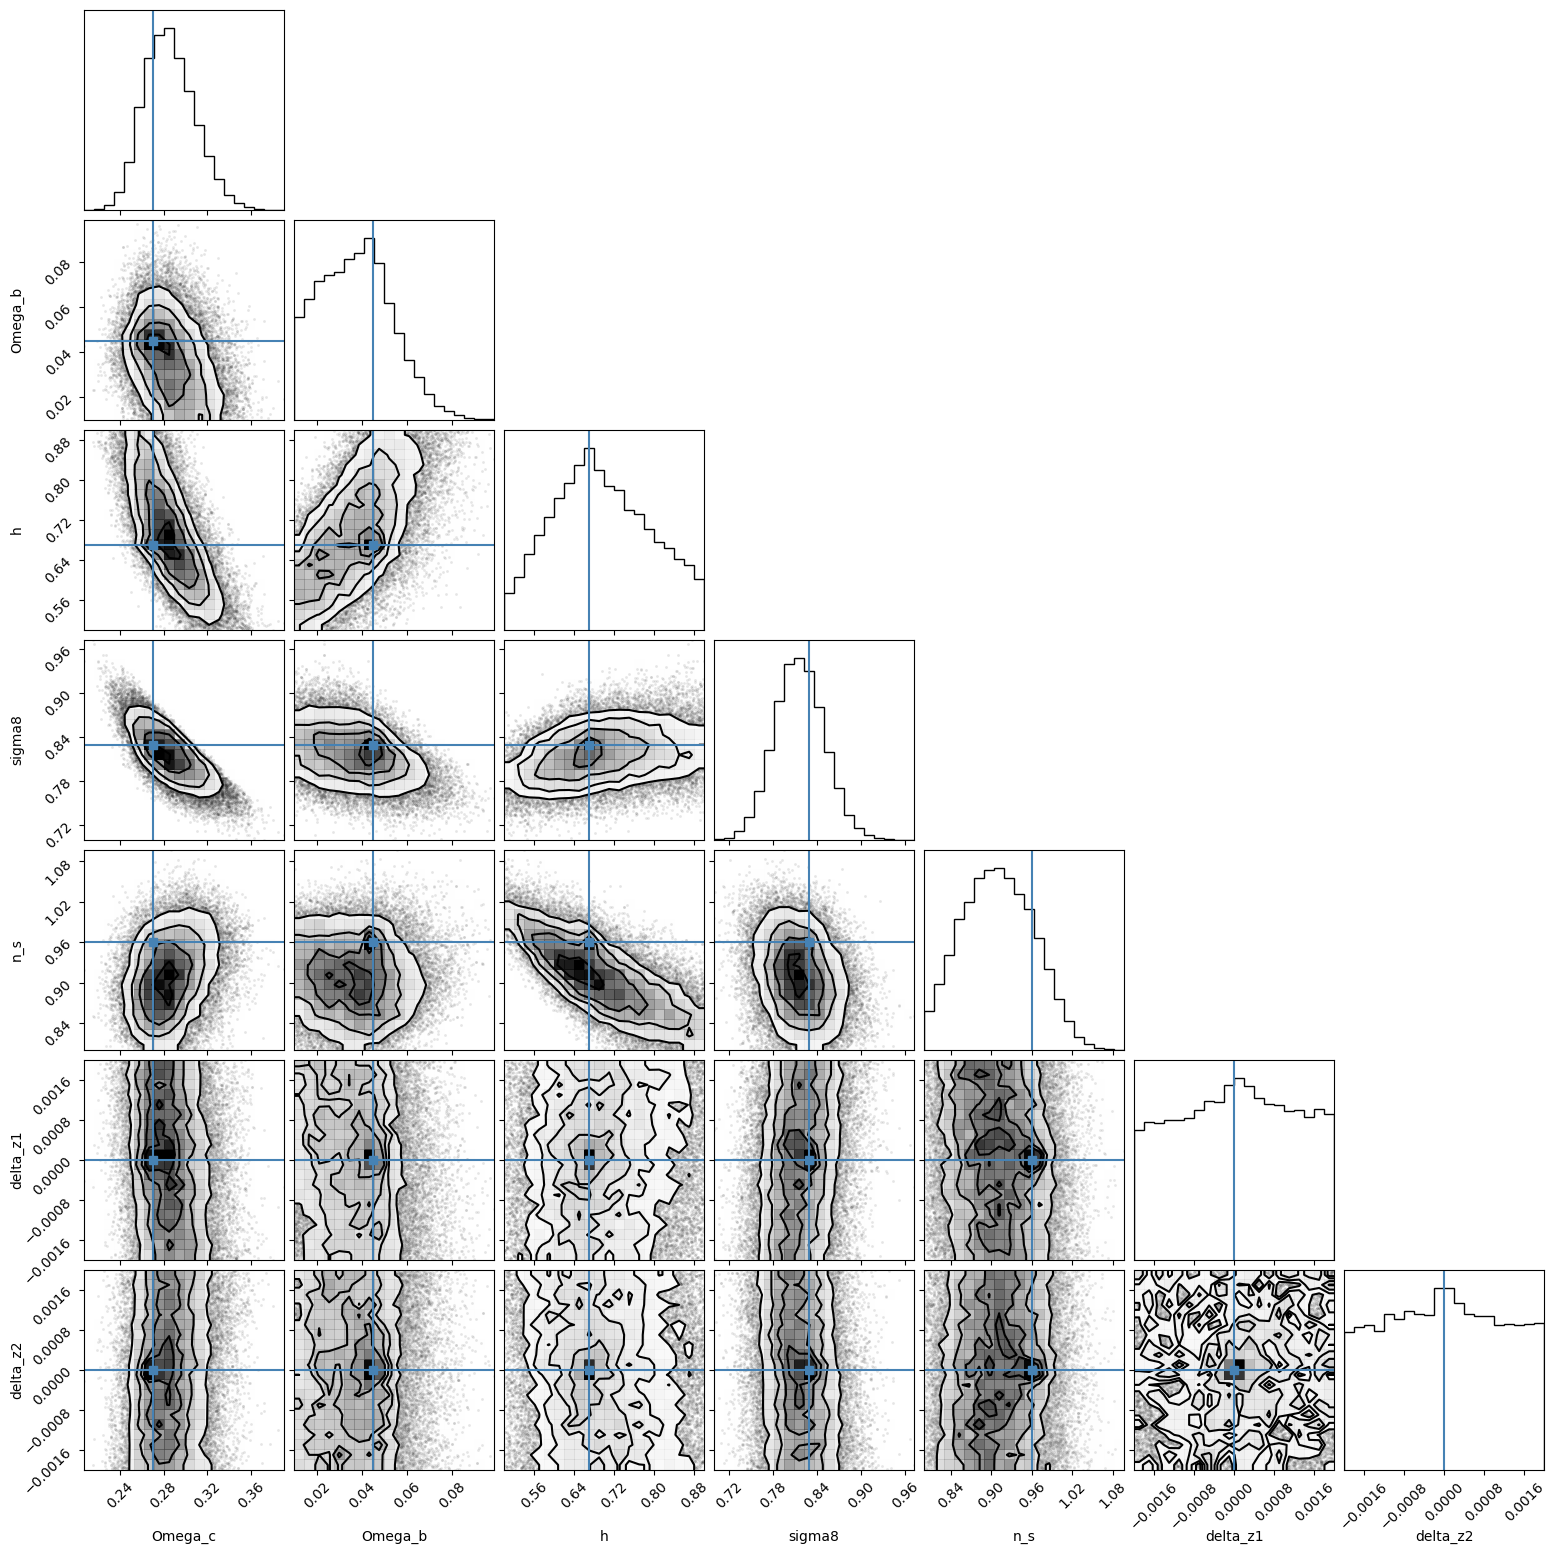

In [9]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[0.27, 0.045, 0.67, 0.83, 0.96, 0.00, 0.00]
);